In [1]:
# importing the libraries
# import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import os
from skimage.transform import resize
from skimage.color import rgb2gray

In [2]:

train_img = []
train_y = []
path = 'C:/Users/varun/Coding/pattern_cnn/dtd/images/'
i=0
for filename in os.listdir(path):
    for images in os.listdir(path+filename) :
        img = imread(path+filename+'/'+images)
        img = rgb2gray(img)
        img = resize(img, (128, 128, 1))
        img = img.astype('float32')
        img /= 255.0
        train_img.append(img)
        train_y.append(i)
    i += 1

In [3]:
len(train_img)

5640

In [4]:
train_x = np.array(train_img)
# defining the target
train_x.shape

(5640, 128, 128, 1)

C:\Users\varun\AppData\Local\Temp\ipykernel_13308\1583486236.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221), plt.imshow(train_x[i]*255, cmap='gray')


(<Axes: >, <matplotlib.image.AxesImage at 0x1edd5eecc10>)

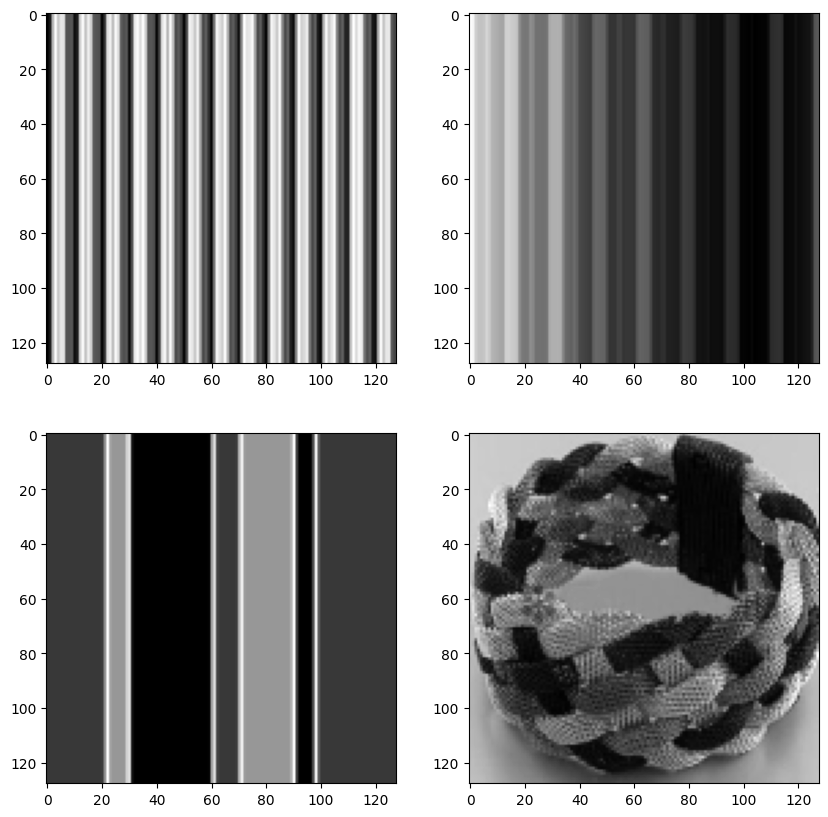

In [7]:
i = 0
plt.figure(figsize=(10,10))
plt.axis("off")
plt.subplot(221), plt.imshow(train_x[i]*255, cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+25]*255, cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50]*255, cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+275]*255, cmap='gray')

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
val_y = np.array(val_y)
train_y = np.array(train_y)
print((train_x.shape, train_y.shape), (val_x.shape, val_y.shape))


In [9]:
np.save("train_x",train_x)
np.save("train_y",train_y)
np.save("val_x",val_x)
np.save("val_y",val_y)

In [ ]:
# converting training images into torch format
train_x = train_x.reshape(5076, 1, 128, 128)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

In [ ]:
# converting validation images into torch format
val_x = val_x.reshape(564, 1, 128, 128)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

In [16]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            Conv2d(1, 32, 5),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),

            Conv2d(32, 64, 5),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(64*29*29, 1024),
            Linear(1024, 47)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0005)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

In [ ]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    model.train()
    tr_loss = 0
    loss_train = 0
    loss_val = 0
    for i in range(5076):
        # getting the training set
        x_train, y_train = Variable(train_x[i:i+1]), Variable(train_y[i:i+1]).type(torch.LongTensor)
        
        # converting the data into GPU format
        if torch.cuda.is_available():
            x_train = x_train.cuda()
            y_train = y_train.cuda()

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()
        
        # prediction for training set
        output_train = model(x_train)

        if torch.cuda.is_available():
            output_train = output_train.cuda()
            
        # computing the training loss
        loss = criterion(output_train, y_train)
        loss_train += loss.item()
        loss.backward()
        optimizer.step()
        
    for i in range(564):
        # # prediction for validation set
        x_val, y_val = Variable(val_x[i:i+1]), Variable(val_y[i:i+1]).type(torch.LongTensor)
        if torch.cuda.is_available():
            x_val = x_val.cuda()
            y_val = y_val.cuda()
        
        output_val = model(x_val)
        loss_val += criterion(output_val, y_val).item()
    
    # Converting loss to tensor format
    loss_train = Variable(torch.tensor((loss_train/5076.0),dtype=torch.float32) , requires_grad=True)
    
    # Appending for plotting graph
    val_losses.append(loss_val/564.0)
    train_losses.append(loss_train/5076.0)

    

    print('Epoch : ',epoch+1, '\t', 'val loss :',loss_val/564.0, '\t', 'train loss :',loss_train)

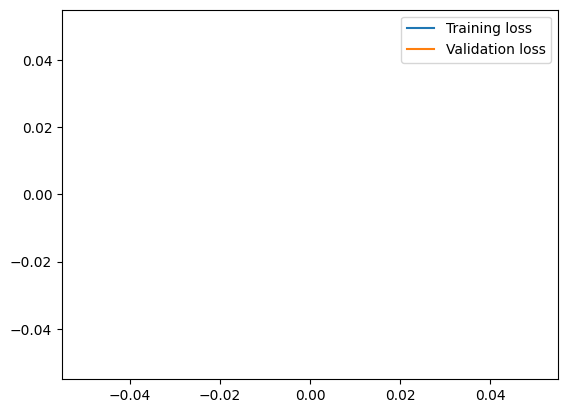

In [ ]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

In [15]:
x = conv1(img)
x = pool(x)
x = drop(x)

x = conv2(x)
x = pool(x)
x = drop(x)

x.shape

torch.Size([64, 29, 29])